In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import json

import pandas as pd

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

In [2]:
with open('/Users/talithaarini/Documents/VS Code/Pengpol/Ektraksi Fiture Sirine.json', 'r') as f:
    Data = json.load(f)

In [3]:
df = pd.DataFrame(Data,columns=['feature','class'])
print(df)

                                               feature      class
0    [-179.03173828125, 200.6383819580078, -15.3265...    traffic
1    [-182.95831298828125, 191.9713897705078, -23.6...    traffic
2    [-190.82022094726562, 191.2377471923828, -27.0...    traffic
3    [-179.11489868164062, 200.8822784423828, -15.5...    traffic
4    [-157.5471954345703, 164.5159454345703, -41.10...    traffic
..                                                 ...        ...
595  [-89.9086685180664, 127.67399597167969, -53.42...  ambulance
596  [-169.7108154296875, 104.45870208740234, -59.5...  ambulance
597  [-189.95802307128906, 124.92961120605469, -55....  ambulance
598  [-144.11634826660156, 100.40633392333984, -50....  ambulance
599  [-369.4662170410156, 24.1889591217041, -69.433...  ambulance

[600 rows x 2 columns]


In [4]:
df['class'].value_counts()

class
traffic      200
firetruck    200
ambulance    200
Name: count, dtype: int64

In [5]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [6]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [8]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from keras.callbacks import EarlyStopping

from sklearn.metrics import f1_score, precision_score, recall_score

In [9]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)

In [11]:
# CNN
def cnn(optimizer="Adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)

    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    conv = GlobalMaxPool1D()(conv)

    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [24]:
model_cnn = cnn(optimizer="Adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 80, 3)             42        
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 3)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 16)            544       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 20, 16)            0         
 g1D)                                                            
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0     

In [19]:
# Callback early stop
early_stop = EarlyStopping(monitor = 'val_acc', mode ='max', patience = 10, restore_best_weights = True)

# Training model
history = model_cnn.fit(X_train_features, y_train, epochs = 200,
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))


Epoch 1/200
8/8 [==============================] - 0s 16ms/step - loss: 6.2252 - acc: 0.3417 - val_loss: 2.1657 - val_acc: 0.3417
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 1.5830 - acc: 0.4146 - val_loss: 0.9061 - val_acc: 0.5333
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 0.7988 - acc: 0.6562 - val_loss: 0.7728 - val_acc: 0.6583
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6978 - acc: 0.6958 - val_loss: 0.6054 - val_acc: 0.7833
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5500 - acc: 0.8146 - val_loss: 0.5177 - val_acc: 0.8000
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5160 - acc: 0.8375 - val_loss: 0.4590 - val_acc: 0.8417
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4405 - acc: 0.8729 - val_loss: 0.4196 - val_acc: 0.8667
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3958 - acc: 0.8771 - va

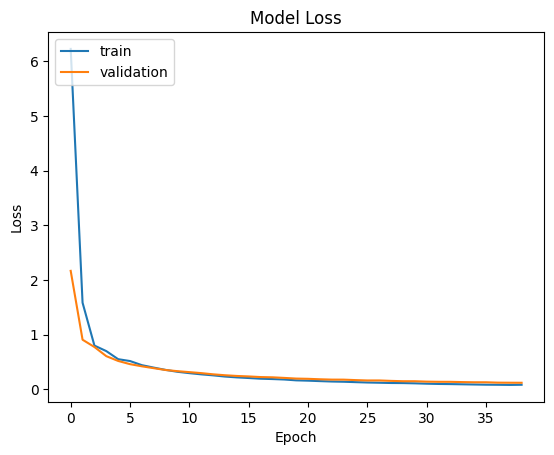

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [25]:
# Evaluasi model dengan data testing
acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc[1])

4/4 [==============================] - 0s 4ms/step - loss: 6.4046 - acc: 0.0500
Test Accuracy :  0.05000000074505806


In [22]:
y_pred = model_cnn.predict(X_test_features)

4/4 [==============================] - 0s 1ms/step


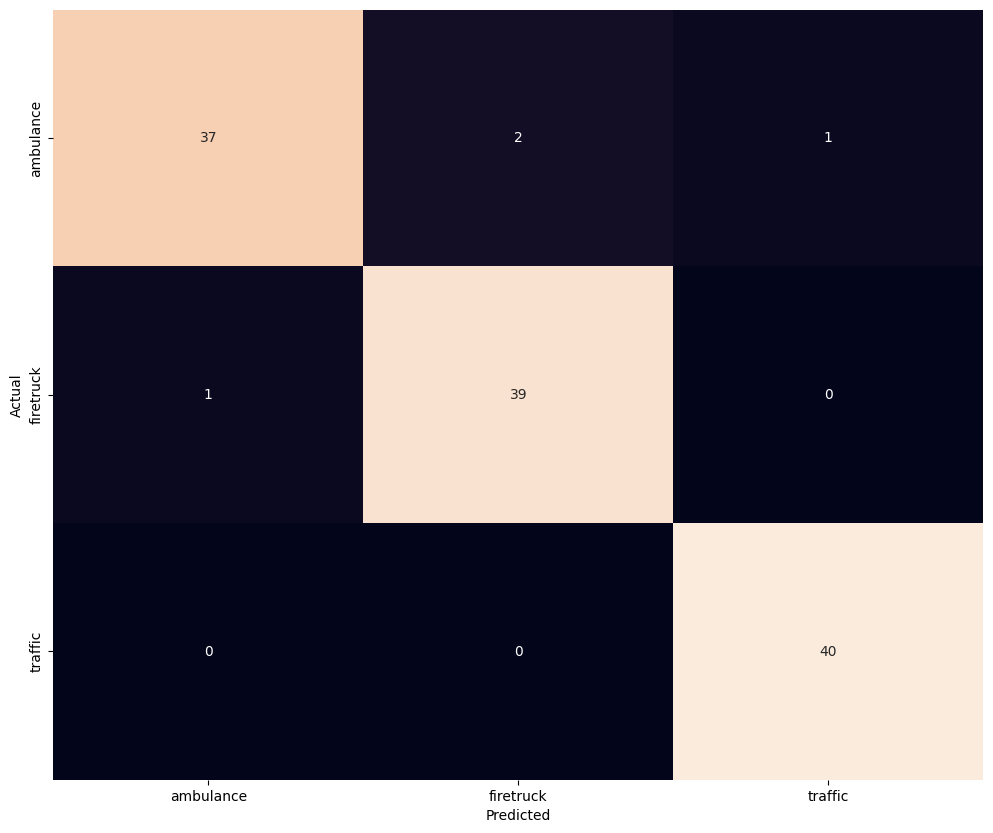

In [26]:
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
y_pred_1d = np.argmax(y_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

f1 = f1_score(y_test_1d, y_pred_1d, average='weighted')
print("F1 Score : ", f1)

precision = precision_score(y_test_1d, y_pred_1d, average='weighted')
print("Precision : ", precision)

recall = recall_score(y_test_1d, y_pred_1d, average='weighted')
print("Recall : ", recall)

F1 Score :  0.9664450775561887
Precision :  0.9668378262729995
Recall :  0.9666666666666667
